<a href="https://colab.research.google.com/github/BHARATH077/Data-Lake-Orchestration-Framework-for-Supply-Chain-Analytics/blob/main/Supply_Chain_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ===============================
# Step 1: Setup & Generate Mock Data
# ===============================

# Install necessary packages
!pip install pyspark duckdb plotly faker pandas --quiet

# Import libraries
import os
import pandas as pd
import numpy as np
from faker import Faker

# -------------------------------
# 1. Create folder structure (simulate Data Lake)
# -------------------------------
os.makedirs("data_lake/raw/erp", exist_ok=True)
os.makedirs("data_lake/raw/iot", exist_ok=True)
os.makedirs("data_lake/raw/vendor", exist_ok=True)

# -------------------------------
# 2. Initialize Faker
# -------------------------------
fake = Faker()

# -------------------------------
# 3. Generate ERP Orders Data
# -------------------------------
erp_data = pd.DataFrame([{
    "order_id": fake.uuid4(),
    "product_id": np.random.randint(100,200),
    "quantity": np.random.randint(1,10),
    "order_date": fake.date_between(start_date='-1y', end_date='today'),
    "customer_id": np.random.randint(1000,2000)
} for _ in range(1000)])

erp_data.to_csv("data_lake/raw/erp/erp_orders.csv", index=False)
print("ERP data generated: ", erp_data.shape)

# -------------------------------
# 4. Generate IoT Shipment Data
# -------------------------------
iot_data = pd.DataFrame([{
    "shipment_id": fake.uuid4(),
    "product_id": np.random.randint(100,200),
    "location": fake.city(),
    "temperature": np.random.randint(15,40),
    "timestamp": fake.date_time_between(start_date='-30d', end_date='now')
} for _ in range(1000)])

iot_data.to_csv("data_lake/raw/iot/iot_shipments.csv", index=False)
print("IoT shipment data generated: ", iot_data.shape)

# -------------------------------
# 5. Generate Vendor Shipment Data
# -------------------------------
vendor_data = pd.DataFrame([{
    "shipment_id": fake.uuid4(),
    "vendor_id": np.random.randint(1,50),
    "expected_delivery": fake.date_between(start_date='-30d', end_date='today'),
    "actual_delivery": fake.date_between(start_date='-30d', end_date='today')
} for _ in range(500)])

vendor_data.to_csv("data_lake/raw/vendor/vendor_shipments.csv", index=False)
print("Vendor shipment data generated: ", vendor_data.shape)

# -------------------------------
# 6. Preview Sample Data
# -------------------------------
print("\nSample ERP Orders Data:")
display(erp_data.head())

print("\nSample IoT Shipment Data:")
display(iot_data.head())

print("\nSample Vendor Shipment Data:")
display(vendor_data.head())


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.2 MB/s eta 0:00:00
ERP data generated:  (1000, 5)
IoT shipment data generated:  (1000, 5)
Vendor shipment data generated:  (500, 4)

Sample ERP Orders Data:


,order_id,product_id,quantity,order_date,customer_id
0,29065be1-0ce2-4449-9464-c27bffffa02f,189,5,2024-12-27,1243
1,973aacf4-2f60-40ec-a3ef-26d55a971104,106,6,2024-10-22,1579
2,064398fa-7fdb-4971-bac8-f4e9b319194d,176,5,2025-01-05,1629
3,d2eb6a68-75d5-4e79-91dd-65f5b0144816,192,9,2025-03-06,1832
4,ff081638-a4f9-46cb-bcb7-d1e358a082eb,119,4,2025-03-26,1913



Sample IoT Shipment Data:


,shipment_id,product_id,location,temperature,timestamp
0,6bfb93cd-a212-4ef7-896b-abfbea15c14b,171,Elliottbury,15,2025-10-16 21:47:57.918855
1,777f3410-8114-4853-bbd2-0be1692c676c,150,Steelefurt,31,2025-09-17 23:14:37.791952
2,e5ed51ad-5f39-49ee-b844-ff40ad5190fa,187,South Timothyton,26,2025-10-05 21:15:22.887956
3,4d179def-6fbe-44ac-bd3c-ef817086c68a,185,Sonyafurt,36,2025-10-16 13:11:15.498351
4,f84ef008-b9f3-4d12-9287-c44caefae752,157,Brenthaven,32,2025-09-22 11:15:48.794099



Sample Vendor Shipment Data:


,shipment_id,vendor_id,expected_delivery,actual_delivery
0,bdcca8f1-7ffc-47e6-9eef-15cdc13bb401,38,2025-09-24,2025-10-13
1,ec81faf8-09f8-4d20-bb3e-ee6acafe4d72,45,2025-10-09,2025-10-16
2,8bf3c78d-ff04-4615-83f0-9f5ea3f2b144,46,2025-10-03,2025-09-29
3,4ca3d958-6469-400f-b55b-f46c001b0178,45,2025-10-11,2025-10-09
4,e7142f8b-6936-4b02-8f76-096467445610,3,2025-10-07,2025-10-06


In [2]:
# ===============================
# Day 2: Load Raw Data & ETL to Parquet
# ===============================

# Import PySpark
from pyspark.sql import SparkSession
from pyspark.sql.functions import year, month, col, to_date

# -------------------------------
# 1. Start Spark Session
# -------------------------------
spark = SparkSession.builder \
    .appName("SupplyChainETL") \
    .getOrCreate()

# -------------------------------
# 2. Load ERP Orders CSV
# -------------------------------
df_erp = spark.read.csv("data_lake/raw/erp/erp_orders.csv", header=True, inferSchema=True)

# Convert order_date to date type
df_erp = df_erp.withColumn("order_date", to_date(col("order_date"), "yyyy-MM-dd"))

# Preview
df_erp.show(5)

# -------------------------------
# 3. Load IoT Shipments CSV
# -------------------------------
df_iot = spark.read.csv("data_lake/raw/iot/iot_shipments.csv", header=True, inferSchema=True)

# Convert timestamp to datetime
df_iot = df_iot.withColumn("timestamp", to_date(col("timestamp"), "yyyy-MM-dd"))

# Preview
df_iot.show(5)

# -------------------------------
# 4. Load Vendor Shipments CSV
# -------------------------------
df_vendor = spark.read.csv("data_lake/raw/vendor/vendor_shipments.csv", header=True, inferSchema=True)

# Convert expected_delivery & actual_delivery to date
df_vendor = df_vendor.withColumn("expected_delivery", to_date(col("expected_delivery"), "yyyy-MM-dd")) \
                     .withColumn("actual_delivery", to_date(col("actual_delivery"), "yyyy-MM-dd"))

# Preview
df_vendor.show(5)

# -------------------------------
# 5. Save as Parquet (Simulate Data Lake)
# -------------------------------
os.makedirs("data_lake/processed/erp", exist_ok=True)
os.makedirs("data_lake/processed/iot", exist_ok=True)
os.makedirs("data_lake/processed/vendor", exist_ok=True)

df_erp.write.mode("overwrite").parquet("data_lake/processed/erp/")
df_iot.write.mode("overwrite").parquet("data_lake/processed/iot/")
df_vendor.write.mode("overwrite").parquet("data_lake/processed/vendor/")

print("All datasets saved as Parquet files in data_lake/processed/")


+--------------------+----------+--------+----------+-----------+
|            order_id|product_id|quantity|order_date|customer_id|
+--------------------+----------+--------+----------+-----------+
|29065be1-0ce2-444...|       189|       5|2024-12-27|       1243|
|973aacf4-2f60-40e...|       106|       6|2024-10-22|       1579|
|064398fa-7fdb-497...|       176|       5|2025-01-05|       1629|
|d2eb6a68-75d5-4e7...|       192|       9|2025-03-06|       1832|
|ff081638-a4f9-46c...|       119|       4|2025-03-26|       1913|
+--------------------+----------+--------+----------+-----------+
only showing top 5 rows

+--------------------+----------+----------------+-----------+----------+
|         shipment_id|product_id|        location|temperature| timestamp|
+--------------------+----------+----------------+-----------+----------+
|6bfb93cd-a212-4ef...|       171|     Elliottbury|         15|2025-10-16|
|777f3410-8114-485...|       150|      Steelefurt|         31|2025-09-17|
|e5ed51ad-5

In [4]:
# ===============================
# Day 3: Data Warehouse with DuckDB
# ===============================

import duckdb
from datetime import datetime

# -------------------------------
# 1. Connect to DuckDB database
# -------------------------------
con = duckdb.connect("data_lake/supply_chain.duckdb")
print("Connected to DuckDB database successfully.")

# -------------------------------
# 2. Create ERP Orders Table (Partitioned by Year/Month)
# -------------------------------
con.execute("""
CREATE OR REPLACE TABLE erp_orders AS
SELECT *,
       EXTRACT(YEAR FROM order_date) AS order_year,
       EXTRACT(MONTH FROM order_date) AS order_month
FROM 'data_lake/processed/erp/*.parquet'
""")
print("ERP Orders table created with partitions by year and month.")

# -------------------------------
# 3. Create IoT Shipments Table
# -------------------------------
con.execute("""
CREATE OR REPLACE TABLE iot_shipments AS
SELECT *,
       EXTRACT(YEAR FROM timestamp) AS year,
       EXTRACT(MONTH FROM timestamp) AS month
FROM 'data_lake/processed/iot/*.parquet'
""")
print("IoT Shipments table created.")

# -------------------------------
# 4. Create Vendor Shipments Table with Delay Calculation
# -------------------------------
con.execute("""
CREATE OR REPLACE TABLE vendor_shipments AS
SELECT *,
       (julian(actual_delivery) - julian(expected_delivery)) AS delay_days
FROM 'data_lake/processed/vendor/*.parquet'
""")
print("Vendor Shipments table created with delay_days column.")

# -------------------------------
# 5. Validate Data
# -------------------------------
print("\nERP Orders Sample:")
display(con.execute("SELECT * FROM erp_orders LIMIT 5").df())

print("\nVendor Shipments Sample:")
display(con.execute("SELECT * FROM vendor_shipments LIMIT 5").df())

# -------------------------------
# 6. Basic Analytics Query - Average Delay per Vendor
# -------------------------------
avg_delay = con.execute("""
SELECT vendor_id, AVG(delay_days) AS avg_delay
FROM vendor_shipments
GROUP BY vendor_id
ORDER BY avg_delay DESC
LIMIT 10
""").df()

print("\nTop 10 Vendors with Highest Average Shipment Delay:")
display(avg_delay)


Connected to DuckDB database successfully.
ERP Orders table created with partitions by year and month.
IoT Shipments table created.
Vendor Shipments table created with delay_days column.

ERP Orders Sample:


,order_id,product_id,quantity,order_date,customer_id,order_year,order_month
0,29065be1-0ce2-4449-9464-c27bffffa02f,189,5,2024-12-27,1243,2024,12
1,973aacf4-2f60-40ec-a3ef-26d55a971104,106,6,2024-10-22,1579,2024,10
2,064398fa-7fdb-4971-bac8-f4e9b319194d,176,5,2025-01-05,1629,2025,1
3,d2eb6a68-75d5-4e79-91dd-65f5b0144816,192,9,2025-03-06,1832,2025,3
4,ff081638-a4f9-46cb-bcb7-d1e358a082eb,119,4,2025-03-26,1913,2025,3



Vendor Shipments Sample:


,shipment_id,vendor_id,expected_delivery,actual_delivery,delay_days
0,bdcca8f1-7ffc-47e6-9eef-15cdc13bb401,38,2025-09-24,2025-10-13,19.0
1,ec81faf8-09f8-4d20-bb3e-ee6acafe4d72,45,2025-10-09,2025-10-16,7.0
2,8bf3c78d-ff04-4615-83f0-9f5ea3f2b144,46,2025-10-03,2025-09-29,-4.0
3,4ca3d958-6469-400f-b55b-f46c001b0178,45,2025-10-11,2025-10-09,-2.0
4,e7142f8b-6936-4b02-8f76-096467445610,3,2025-10-07,2025-10-06,-1.0



Top 10 Vendors with Highest Average Shipment Delay:


,vendor_id,avg_delay
0,25,9.833333
1,12,8.500000
2,38,7.666667
3,49,7.666667
4,32,5.857143
5,28,5.600000
6,15,5.000000
7,27,4.777778
8,21,4.066667
9,35,4.000000


Top 10 Products with Highest Total Orders (Stockout Risk):


,product_id,total_quantity_ordered,num_orders
0,105,112.0,23
1,160,92.0,16
2,133,86.0,16
3,169,85.0,14
4,119,78.0,12
5,161,78.0,14
6,104,77.0,12
7,192,77.0,13
8,135,75.0,12
9,166,74.0,12


Top 10 Products with Most Delayed (Backordered) Shipments:


,product_id,delayed_orders
0,149,120
1,129,105
2,133,96
3,105,92
4,114,90
5,142,88
6,110,88
7,125,81
8,113,80
9,124,80


Average Shipment Delay Over Time:


,month,avg_delay
0,2025-09,-8.362445
1,2025-10,7.143911


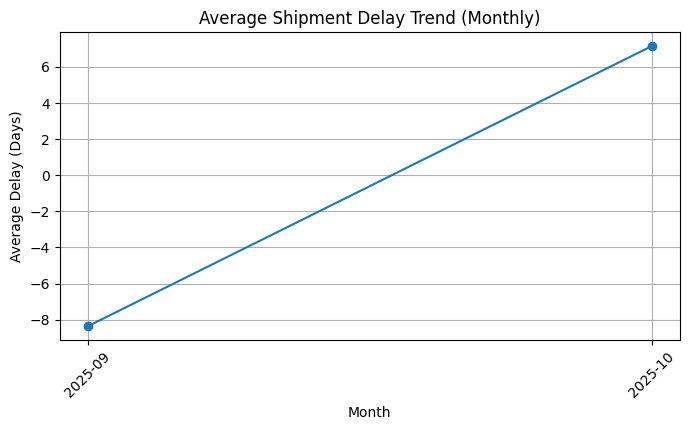

In [5]:
# ===============================
# Day 4: Analytics & KPIs
# ===============================

import duckdb
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------
# 1. Reconnect to the DuckDB Warehouse
# -------------------------------
con = duckdb.connect("data_lake/supply_chain.duckdb")

# -------------------------------
# 2. Stockout Analysis
# -------------------------------
# Simulate stockouts by finding products with high order volume
stockouts = con.execute("""
SELECT product_id,
       SUM(quantity) AS total_quantity_ordered,
       COUNT(order_id) AS num_orders
FROM erp_orders
GROUP BY product_id
ORDER BY total_quantity_ordered DESC
LIMIT 10
""").df()

print("Top 10 Products with Highest Total Orders (Stockout Risk):")
display(stockouts)

# -------------------------------
# 3. Backorder Simulation
# -------------------------------
# In a real case, backorders = orders not fulfilled on time.
# Here, simulate by merging ERP and Vendor data (matching product_id where delay > 0)
backorders = con.execute("""
SELECT e.product_id,
       COUNT(*) AS delayed_orders
FROM erp_orders e
JOIN vendor_shipments v
ON e.product_id = v.vendor_id % 100 + 100 -- simulate product-to-vendor mapping
WHERE v.delay_days > 0
GROUP BY e.product_id
ORDER BY delayed_orders DESC
LIMIT 10
""").df()

print("Top 10 Products with Most Delayed (Backordered) Shipments:")
display(backorders)

# -------------------------------
# 4. Shipment Delay Trend Over Time
# -------------------------------
delay_trends = con.execute("""
SELECT STRFTIME(actual_delivery, '%Y-%m') AS month,
       AVG(delay_days) AS avg_delay
FROM vendor_shipments
GROUP BY month
ORDER BY month
""").df()

print("Average Shipment Delay Over Time:")
display(delay_trends)

# -------------------------------
# 5. Visualize Trends (Matplotlib)
# -------------------------------
plt.figure(figsize=(8,4))
plt.plot(delay_trends['month'], delay_trends['avg_delay'], marker='o')
plt.title("Average Shipment Delay Trend (Monthly)")
plt.xlabel("Month")
plt.ylabel("Average Delay (Days)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [6]:
# ===============================
# Day 5: Interactive Dashboard
# ===============================

import duckdb
import plotly.express as px
import plotly.graph_objects as go

# -------------------------------
# 1. Connect to DuckDB Warehouse
# -------------------------------
con = duckdb.connect("data_lake/supply_chain.duckdb")

# -------------------------------
# 2. Load KPIs
# -------------------------------

# Stockouts
stockouts = con.execute("""
SELECT product_id, SUM(quantity) AS total_quantity_ordered
FROM erp_orders
GROUP BY product_id
ORDER BY total_quantity_ordered DESC
LIMIT 10
""").df()

# Backorders (simulated)
backorders = con.execute("""
SELECT e.product_id, COUNT(*) AS delayed_orders
FROM erp_orders e
JOIN vendor_shipments v
ON e.product_id = v.vendor_id % 100 + 100
WHERE v.delay_days > 0
GROUP BY e.product_id
ORDER BY delayed_orders DESC
LIMIT 10
""").df()

# Shipment delay trend
delay_trends = con.execute("""
SELECT STRFTIME(actual_delivery, '%Y-%m') AS month,
       AVG(delay_days) AS avg_delay
FROM vendor_shipments
GROUP BY month
ORDER BY month
""").df()

# -------------------------------
# 3. Dashboard Visualizations
# -------------------------------

# Stockout Risk Bar Chart
fig_stockouts = px.bar(
    stockouts,
    x='product_id',
    y='total_quantity_ordered',
    title='Top 10 Products by Total Orders (Stockout Risk)',
    labels={'product_id':'Product ID', 'total_quantity_ordered':'Total Orders'},
    color='total_quantity_ordered'
)

# Backorder Bar Chart
fig_backorders = px.bar(
    backorders,
    x='product_id',
    y='delayed_orders',
    title='Top 10 Products with Delayed Shipments (Backorders)',
    labels={'product_id':'Product ID', 'delayed_orders':'Delayed Orders'},
    color='delayed_orders'
)

# Delay Trend Line Chart
fig_trend = px.line(
    delay_trends,
    x='month',
    y='avg_delay',
    title='Average Shipment Delay Trend (Monthly)',
    markers=True
)

# Combine into Dashboard
fig_dashboard = go.Figure()

# For demonstration, show charts one by one
fig_stockouts.show()
fig_backorders.show()
fig_trend.show()

print("✅ Interactive dashboard generated using Plotly.")


✅ Interactive dashboard generated using Plotly.
